# Creating a K-Nearest Neighbors Machine Learning Classifier 

**Having created an SVC Classifier model (*see MachineLearningSVC.jpynb*), we next wanted to see if a K-Nearest Neighbors Classifier would perform better on predicting the genre of songs.**

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

**As before, we obtained all of the features we were interested in that were gathered during the data collection phase, and merged them into one data frame called songs.**

In [2]:
given = pickle.load(open("cleanedData.pkl", "rb"))
audio_analysis = pickle.load(open("audio_analysis_df.pkl", "rb"))
key_analysis = pickle.load(open("key_analysis_df.pkl", "rb"))
lengths_df = pickle.load(open("lengths_df.pkl", "rb"))
songs = pd.concat([given, audio_analysis, key_analysis, lengths_df], axis=1)

**Below are all of the features we currently have access to in the songs dataframe:**

In [3]:
songs.columns

Index(['artist', 'genre', 'lyrics', 'num_syllables', 'pos', 'year',
       'fog_index', 'flesch_index', 'num_words', 'num_lines', 'title',
       'f_k_grade', 'difficult_words', 'num_dupes', 'neg', 'neu', 'compound',
       'id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'uri',
       'analysis_url', 'artist_with_features', 'year_bin', 'image', 'cluster',
       'Gender', 'duration_avg', 'loudness_end_avg', 'loudness_max_avg',
       'loudness_max_time_avg', 'loudness_start_avg', 'key_changes',
       'num_sections', 'num_segments'],
      dtype='object')

**From this large list of features, we extracted the ones that we thought would be effective at predicting genre based on some experimentation, the previous SVC model's results, and our initial data exploration.**

In [4]:
features = ['genre', 'lyrics', 'num_words', 'num_lines',
       'num_dupes', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 
            'year_bin', 'duration_avg', 'loudness_end_avg', 'loudness_max_avg',
       'loudness_max_time_avg', 'loudness_start_avg', 'key_changes',
       'num_sections', 'num_segments']

**Once again, we dropped the songs containing na values so as to avoid error and not use songs with incomplete feature sets.  Our x-training set was defined initially to consist of the features defined above, ignoring lyrics and genre, and our y-training set was defined to be the genre.  We used a DictVectorizer to create dummy variables of the categorical labels in the x-training data, scaled all the variables, and trained a K-Nearest_Neighbors model.  We used cross-validation and measured the f1 mean scores from each of these cross-validations.  The f1 scores of various classes were looked at, such as rock, jazz, and pop, with rock being displayed below.  Finally, we optimized the k-value with respect to the f1 scores (each class falling in a similar range), and decided to go with k=41 for a model that does not use a TF-IDF vectorizer.**

In [5]:
data = songs[features].dropna()

6     0.556846
1     0.563728
16    0.595884
11    0.603492
26    0.603695
36    0.610799
21    0.612508
31    0.616745
46    0.627891
41    0.629612
dtype: float64

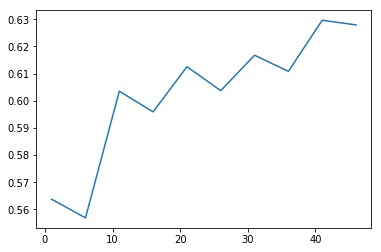

In [6]:
%matplotlib inline


X_train = data.drop(["lyrics","genre"], axis=1)
y_train = data["genre"]
X_dict = X_train.to_dict(orient="records")  
is_rock_train = (y_train=="rock")
is_jazz_train = (y_train == "jazz")
is_pop_train = (y_train == "pop")

# Use the features that we would like
df_features = data.drop(["lyrics","genre"], axis=1).reset_index().drop("index", axis=1)
    

  
    
def get_f1(k):
    #print(str(k))
    model = KNeighborsClassifier(n_neighbors=k)
    scaler = StandardScaler()
    vec = DictVectorizer(sparse=False)
    pipeline = Pipeline([("vec", vec), ("scaler", scaler), ("model", model)])
    f1 = cross_val_score(pipeline, X_dict, is_rock_train, cv=10, scoring="f1").mean()
    return f1
    
ks = pd.Series(range(1, 51, 5))
ks.index = range(1, 51, 5)
test_errs = ks.apply(get_f1)

test_errs.plot.line()
test_errs.sort_values()

**Next, as we did with the SVC model, we performed a K-Nearest Neighbors Classifier model again, this time taking into account word frequencies with respect to TF-IDF.  (A Principle Component Analysis was also attempted as with the SVC model, but unlike the SVC, it performed worse in this model than without).  An optimal k-value was found once again with respect to various f1 scores, looking once again at several classes.  The code segments and graphs for optimizing k with respect to the f1 in jazz and rock are displayed below.**

36    0.000000
41    0.000000
46    0.000000
31    0.016667
16    0.021739
21    0.028571
26    0.036364
6     0.037607
11    0.042222
1     0.220700
dtype: float64

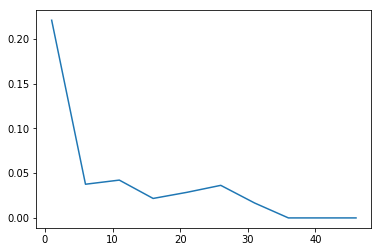

In [7]:
lyrics = data["lyrics"].replace("\n", " ")
vector = TfidfVectorizer(norm=None, min_df = 0.01, stop_words={"english"}, lowercase=True) # Do not normalize.
vector.fit(lyrics) # This determines the vocabulary.
tf_idf_sparse = vector.transform(lyrics)
lyrics = pd.DataFrame(tf_idf_sparse.todense())
lyrics.columns = vector.vocabulary_

X_train = data.drop(["lyrics","genre"], axis=1)
y_train = data["genre"]
X_dict = X_train.to_dict(orient="records")  
is_jazz_train = (y_train=="jazz")

    
# Create X_train and y_train
X_train = pd.concat([df_features, lyrics], axis = 1, sort=False)
y_train = data["genre"]
    
# Vectorize the categorical variables
X_dict = X_train.to_dict(orient="records")
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()
  
    
def get_f1(k):
    #print(str(k))
    model = KNeighborsClassifier(n_neighbors=k)
    scaler = StandardScaler()
    vec = DictVectorizer(sparse=False)
    pipeline = Pipeline([("vec", vec), ("scaler", scaler), ("model", model)])
    f1 = cross_val_score(pipeline, X_dict, is_jazz_train, cv=10, scoring="f1").mean()
    #print("here")
    return f1
    
ks = pd.Series(range(1, 51, 5))
ks.index = range(1, 51, 5)
test_errs = ks.apply(get_f1)

test_errs.plot.line()
test_errs.sort_values()

**The graph above predicted k=1 to be the optimal k-value with regards to f1 for jazz.  As we know, this is not a truly good value for k.  Other values that predicted the highest f1 scores were k=11, 6 and 26.  While these f1 scores are somewhat poor, it is likely due to the fact that there are fewer jazz songs in our data set of top songs over the decades.**

6     0.359580
11    0.491347
16    0.528065
1     0.531255
21    0.585770
26    0.587730
46    0.598505
31    0.602621
41    0.603307
36    0.604901
dtype: float64

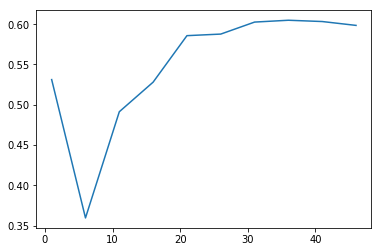

In [15]:
lyrics = data["lyrics"].replace("\n", " ")
vector = TfidfVectorizer(norm=None, min_df = 0.01, stop_words={"english"}, lowercase=True) # Do not normalize.
vector.fit(lyrics) # This determines the vocabulary.
tf_idf_sparse = vector.transform(lyrics)
lyrics = pd.DataFrame(tf_idf_sparse.todense())
lyrics.columns = vector.vocabulary_

X_train = data.drop(["lyrics","genre"], axis=1)
y_train = data["genre"]
X_dict = X_train.to_dict(orient="records")  
is_rock_train = (y_train=="rock")

    
# Create X_train and y_train
X_train = pd.concat([df_features, lyrics], axis = 1, sort=False)
y_train = data["genre"]
    
# Vectorize the categorical variables
X_dict = X_train.to_dict(orient="records")
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()

  
    
def get_accuracy(k):
    #print(str(k))
    model = KNeighborsClassifier(n_neighbors=k)
    scaler = StandardScaler()
    vec = DictVectorizer(sparse=False)
    pipeline = Pipeline([("vec", vec), ("scaler", scaler), ("model", model)])
    accuracy = cross_val_score(pipeline, X_dict, is_rock_train, cv=10, scoring="f1").mean()
    return accuracy
    
ks = pd.Series(range(1, 51, 5))
ks.index = range(1, 51, 5)
test_errs = ks.apply(get_accuracy)

test_errs.plot.line()
test_errs.sort_values()

**In contrast, looking at the f1 scores of rock as our class with respect to optimizing k, these measures performed much better overall.  This is likely due to there being a far greater number of rock songs in our data set.  We found an optimal value of k for a K-Nearest-Neighbors Classifier considering TF-IDF to be 36 in this case.**